# Momotaro RAG Experiment - exp_003 (Ollama + nomic-v2-moe)

このノートブックでは、桃太郎の物語に関するRAG（Retrieval-Augmented Generation）システムを**Ollama + nomic-embed-text v2 (MoE)**で実装します。

## 目標
- 日本語の桃太郎テキストを読み込む
- テキストをチャンクに分割
- FAISSベクトルインデックスを作成（nomic-v2 MoE埋め込み使用）
- テスト質問に対してRAG有無での回答を比較
- exp_001 (nomic-v1) との埋め込み品質を比較

## 必要な準備
1. `data/raw/japanese/` に桃太郎のテキストファイルを3-5個配置
2. Ollamaが起動していることを確認
3. 必要なモデルがインストール済み:
   - `ollama pull phi3`
   - `ollama pull nomic-embed-text-v2-moe`

## 1. セットアップとインポート

In [1]:
import os
import sys
import json
from pathlib import Path
from typing import List, Dict, Tuple
import re

# Data processing
import numpy as np
import pandas as pd
from dotenv import load_dotenv

# Vector store
import faiss

# LLM
import ollama

# Encoding detection
from charset_normalizer import from_path

# Load environment variables
load_dotenv()

# Configuration
LLM_PROVIDER = 'ollama'
OLLAMA_BASE_URL = os.getenv('OLLAMA_BASE_URL', 'http://localhost:11434')
OLLAMA_MODEL = os.getenv('OLLAMA_MODEL_NAME', 'phi3')
EMBEDDING_MODEL = 'nomic-embed-text-v2-moe'  # v2 MoEを使用
CHUNK_SIZE = int(os.getenv('CHUNK_SIZE', 500))
CHUNK_OVERLAP = int(os.getenv('CHUNK_OVERLAP', 50))
TOP_K = int(os.getenv('TOP_K_RESULTS', 3))
VECTOR_DIM = int(os.getenv('VECTOR_DIMENSION', 768))

# Experiment Configuration
EXPERIMENT_ID = "exp_003_moe_ollama_phi3_nomic-v2-moe"

# Paths - 実験単位で管理
PROJECT_ROOT = Path.cwd().parent.parent  # From experiments/exp_XXX/ to project root
EXPERIMENT_PATH = PROJECT_ROOT / "experiments" / EXPERIMENT_ID
DATA_RAW_PATH = PROJECT_ROOT / "data" / "raw" / "japanese"
DATA_VECTORS_PATH = EXPERIMENT_PATH / "vectors"
RESULTS_PATH = EXPERIMENT_PATH / "results"
CONFIG_PATH = EXPERIMENT_PATH / "config.json"

# Create paths if they don't exist
DATA_VECTORS_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print("✓ Setup complete")
print(f"  - Experiment ID: {EXPERIMENT_ID}")
print(f"  - LLM Provider: {LLM_PROVIDER}")
print(f"  - Ollama Model: {OLLAMA_MODEL}")
print(f"  - Embedding Model: {EMBEDDING_MODEL} (MoE)")
print(f"  - Data path: {DATA_RAW_PATH}")
print(f"  - Vectors path: {DATA_VECTORS_PATH}")
print(f"  - Results path: {RESULTS_PATH}")

✓ Setup complete
  - Experiment ID: exp_003_moe_ollama_phi3_nomic-v2-moe
  - LLM Provider: ollama
  - Ollama Model: phi3
  - Embedding Model: nomic-embed-text-v2-moe (MoE)
  - Data path: /Users/igomuni/MyGitHub/RagLab001/data/raw/japanese
  - Vectors path: /Users/igomuni/MyGitHub/RagLab001/experiments/exp_003_moe_ollama_phi3_nomic-v2-moe/vectors
  - Results path: /Users/igomuni/MyGitHub/RagLab001/experiments/exp_003_moe_ollama_phi3_nomic-v2-moe/results


## 2. Ollama接続テスト

In [2]:
# Ollamaが起動しているか確認
try:
    models = ollama.list()
    print("✓ Ollama is running")
    print("\nAvailable models:")
    for model in models['models']:
        print(f"  - {model['name']}")
    
    # 必要なモデルの確認
    model_names = [m['name'] for m in models['models']]
    
    if any(OLLAMA_MODEL in name for name in model_names):
        print(f"\n✓ LLM model '{OLLAMA_MODEL}' is available")
    else:
        print(f"\n⚠ Warning: LLM model '{OLLAMA_MODEL}' not found")
        print(f"  Please run: ollama pull {OLLAMA_MODEL}")
    
    if any(EMBEDDING_MODEL in name for name in model_names):
        print(f"✓ Embedding model '{EMBEDDING_MODEL}' is available")
    else:
        print(f"\n⚠ Warning: Embedding model '{EMBEDDING_MODEL}' not found")
        print(f"  Please run: ollama pull {EMBEDDING_MODEL}")
        
except Exception as e:
    print(f"✗ Error connecting to Ollama: {e}")
    print(f"  Make sure Ollama is running on {OLLAMA_BASE_URL}")

✓ Ollama is running

Available models:
  - nomic-embed-text-v2-moe:latest
  - nomic-embed-text:latest
  - phi3:latest
  - qwen2.5:3b
  - qwen3:8b
  - qwen2.5:7b

✓ LLM model 'phi3' is available
✓ Embedding model 'nomic-embed-text-v2-moe' is available


## 3. データロードと前処理

In [3]:
def detect_encoding(file_path: Path) -> str:
    """
    ファイルのエンコーディングを自動検出
    """
    result = from_path(file_path).best()
    return result.encoding if result else 'utf-8'

def load_text_file(file_path: Path) -> Dict[str, str]:
    """
    テキストファイルを読み込み、メタデータとともに返す
    """
    encoding = detect_encoding(file_path)
    
    try:
        with open(file_path, 'r', encoding=encoding) as f:
            content = f.read()
        
        return {
            'source': file_path.name,
            'path': str(file_path),
            'language': 'ja',
            'encoding': encoding,
            'content': content,
            'char_count': len(content)
        }
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def preprocess_text(text: str) -> str:
    """
    テキストの前処理
    - 余分な空白を削除
    - 改行を正規化
    """
    # 連続する空白を1つに
    text = re.sub(r'[ \t]+', ' ', text)
    
    # 3つ以上の連続する改行を2つに
    text = re.sub(r'\n{3,}', '\n\n', text)
    
    # 行頭・行末の空白を削除
    text = '\n'.join(line.strip() for line in text.split('\n'))
    
    return text.strip()

# データの読み込み
print("Loading Japanese Momotaro texts...")
text_files = list(DATA_RAW_PATH.glob('*.txt'))

if not text_files:
    print(f"⚠ No text files found in {DATA_RAW_PATH}")
    print("Please add Momotaro text files to data/raw/japanese/")
else:
    documents = []
    for file_path in text_files:
        doc = load_text_file(file_path)
        if doc:
            doc['content'] = preprocess_text(doc['content'])
            documents.append(doc)
            print(f"  ✓ Loaded: {doc['source']} ({doc['char_count']:,} chars, {doc['encoding']})")
    
    print(f"\n✓ Total documents loaded: {len(documents)}")

Loading Japanese Momotaro texts...
  ✓ Loaded: aozora_jp_001.txt (2,001 chars, utf_8)
  ✓ Loaded: children_jp_003.txt (1,454 chars, utf_8)
  ✓ Loaded: traditional_jp_002.txt (3,197 chars, utf_8)

✓ Total documents loaded: 3


## 4. テキストのチャンク化

In [4]:
def chunk_by_paragraphs(text: str, max_chars: int = CHUNK_SIZE, overlap: int = CHUNK_OVERLAP) -> List[str]:
    """
    段落ベースでテキストをチャンク化
    段落が長すぎる場合は文単位で分割
    """
    # 段落で分割（空行で区切られた部分）
    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
    
    chunks = []
    current_chunk = ""
    
    for para in paragraphs:
        # 段落が最大サイズを超える場合
        if len(para) > max_chars:
            # 現在のチャンクを保存
            if current_chunk:
                chunks.append(current_chunk.strip())
                current_chunk = ""
            
            # 長い段落を文単位で分割
            sentences = re.split(r'([。！？])', para)
            sentences = [''.join(sentences[i:i+2]) for i in range(0, len(sentences), 2)]
            
            for sent in sentences:
                if len(current_chunk) + len(sent) <= max_chars:
                    current_chunk += sent
                else:
                    if current_chunk:
                        chunks.append(current_chunk.strip())
                    current_chunk = sent
        else:
            # 段落を追加できるか確認
            if len(current_chunk) + len(para) + 2 <= max_chars:  # +2 for \n\n
                if current_chunk:
                    current_chunk += "\n\n" + para
                else:
                    current_chunk = para
            else:
                if current_chunk:
                    chunks.append(current_chunk.strip())
                current_chunk = para
    
    # 最後のチャンクを追加
    if current_chunk:
        chunks.append(current_chunk.strip())
    
    return chunks

def create_chunks_with_metadata(documents: List[Dict]) -> List[Dict]:
    """
    全ドキュメントをチャンク化し、メタデータを付加
    """
    all_chunks = []
    
    for doc in documents:
        chunks = chunk_by_paragraphs(doc['content'], CHUNK_SIZE, CHUNK_OVERLAP)
        
        for idx, chunk_text in enumerate(chunks):
            chunk = {
                'chunk_id': f"{doc['source']}_{idx:03d}",
                'text': chunk_text,
                'source': doc['source'],
                'language': doc['language'],
                'position': idx,
                'char_count': len(chunk_text)
            }
            all_chunks.append(chunk)
    
    return all_chunks

# チャンク作成
print("Creating chunks...")
chunks = create_chunks_with_metadata(documents)
print(f"✓ Created {len(chunks)} chunks")

# チャンクのサンプル表示
if chunks:
    print("\nSample chunks:")
    for i, chunk in enumerate(chunks[:3]):
        print(f"\n--- Chunk {i+1}: {chunk['chunk_id']} ---")
        print(f"Source: {chunk['source']}")
        print(f"Length: {chunk['char_count']} chars")
        print(f"Text preview: {chunk['text'][:100]}...")

Creating chunks...
✓ Created 15 chunks

Sample chunks:

--- Chunk 1: aozora_jp_001.txt_000 ---
Source: aozora_jp_001.txt
Length: 493 chars
Text preview: 桃太郎

むかしむかし、あるところに、おじいさんとおばあさんが住んでいました。

一、桃太郎の誕生

おじいさんは山へ柴刈りに、おばあさんは川へ洗濯に行きました。おばあさんが川で洗濯をしていると、どん...

--- Chunk 2: aozora_jp_001.txt_001 ---
Source: aozora_jp_001.txt
Length: 462 chars
Text preview: ある日、桃太郎はおじいさんとおばあさんに言いました。

「鬼ヶ島へ行って、鬼を退治してきます。村のみんなのためにも、育ててくれたお二人のためにも、僕が鬼をやっつけます」

おばあさんは心配しましたが、...

--- Chunk 3: aozora_jp_001.txt_002 ---
Source: aozora_jp_001.txt
Length: 434 chars
Text preview: 桃太郎は猿にもきびだんごを一つあげました。猿も喜んで、桃太郎のお供になりました。

さらに進んでいくと、今度は一羽のキジに出会いました。

「桃太郎さん、どこへ行かれるのですか」
「鬼ヶ島へ、鬼退治に...


## 5. エンベディング生成とFAISSインデックス構築

In [5]:
def generate_embedding(text: str, model: str = EMBEDDING_MODEL) -> np.ndarray:
    """
    Ollamaを使ってテキストのエンベディングを生成
    """
    try:
        response = ollama.embeddings(model=model, prompt=text)
        return np.array(response['embedding'], dtype=np.float32)
    except Exception as e:
        print(f"Error generating embedding: {e}")
        return None

def generate_embeddings_batch(texts: List[str], model: str = EMBEDDING_MODEL) -> np.ndarray:
    """
    複数テキストのエンベディングを生成
    """
    embeddings = []
    
    for i, text in enumerate(texts):
        if (i + 1) % 10 == 0:
            print(f"  Processing {i+1}/{len(texts)}...")
        
        emb = generate_embedding(text, model)
        if emb is not None:
            embeddings.append(emb)
        else:
            # エラーの場合はゼロベクトル
            embeddings.append(np.zeros(VECTOR_DIM, dtype=np.float32))
    
    return np.array(embeddings)

def create_faiss_index(embeddings: np.ndarray) -> faiss.Index:
    """
    FAISSインデックスを作成
    """
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)  # L2距離を使用
    index.add(embeddings)
    return index

# エンベディング生成
print("Generating embeddings with Ollama...")
print("This may take a few minutes depending on the number of chunks.")

chunk_texts = [chunk['text'] for chunk in chunks]
embeddings = generate_embeddings_batch(chunk_texts)

print(f"✓ Generated {len(embeddings)} embeddings")
print(f"  Embedding dimension: {embeddings.shape[1]}")

# FAISSインデックス作成
print("\nCreating FAISS index...")
index = create_faiss_index(embeddings)
print(f"✓ FAISS index created with {index.ntotal} vectors")

# インデックスとメタデータを保存（Ollama専用ディレクトリ）
index_path = DATA_VECTORS_PATH / "index.faiss"
metadata_path = DATA_VECTORS_PATH / "metadata.json"

faiss.write_index(index, str(index_path))
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(chunks, f, ensure_ascii=False, indent=2)

print(f"\n✓ Saved index to {index_path}")
print(f"✓ Saved metadata to {metadata_path}")

Generating embeddings with Ollama...
This may take a few minutes depending on the number of chunks.
  Processing 10/15...
✓ Generated 15 embeddings
  Embedding dimension: 768

Creating FAISS index...
✓ FAISS index created with 15 vectors

✓ Saved index to /Users/igomuni/MyGitHub/RagLab001/experiments/exp_003_moe_ollama_phi3_nomic-v2-moe/vectors/index.faiss
✓ Saved metadata to /Users/igomuni/MyGitHub/RagLab001/experiments/exp_003_moe_ollama_phi3_nomic-v2-moe/vectors/metadata.json


## 6. 検索機能の実装

In [6]:
def search_similar_chunks(query: str, index: faiss.Index, chunks: List[Dict], k: int = TOP_K) -> List[Dict]:
    """
    クエリに類似したチャンクを検索
    """
    # クエリのエンベディング生成
    query_embedding = generate_embedding(query)
    if query_embedding is None:
        return []
    
    # 検索実行
    query_embedding = query_embedding.reshape(1, -1)
    distances, indices = index.search(query_embedding, k)
    
    # 結果を整形
    results = []
    for dist, idx in zip(distances[0], indices[0]):
        if idx < len(chunks):
            result = chunks[idx].copy()
            result['distance'] = float(dist)
            result['similarity'] = 1 / (1 + dist)  # 類似度スコア
            results.append(result)
    
    return results

# 検索のテスト
print("Testing retrieval...")
test_query = "桃太郎はどこから生まれましたか"
results = search_similar_chunks(test_query, index, chunks, k=3)

print(f"\nQuery: {test_query}")
print(f"Found {len(results)} relevant chunks:\n")

for i, result in enumerate(results, 1):
    print(f"Result {i}:")
    print(f"  Source: {result['source']}")
    print(f"  Chunk ID: {result['chunk_id']}")
    print(f"  Similarity: {result['similarity']:.4f}")
    print(f"  Text: {result['text'][:150]}...")
    print()

Testing retrieval...

Query: 桃太郎はどこから生まれましたか
Found 3 relevant chunks:

Result 1:
  Source: aozora_jp_001.txt
  Chunk ID: aozora_jp_001.txt_000
  Similarity: 0.0063
  Text: 桃太郎

むかしむかし、あるところに、おじいさんとおばあさんが住んでいました。

一、桃太郎の誕生

おじいさんは山へ柴刈りに、おばあさんは川へ洗濯に行きました。おばあさんが川で洗濯をしていると、どんぶらこ、どんぶらこと、大きな桃が流れてきました。

「これは良い桃じゃ。持って帰っておじいさんと食べ...

Result 2:
  Source: traditional_jp_002.txt
  Chunk ID: traditional_jp_002.txt_001
  Similarity: 0.0061
  Text: 二人は包丁を持ってきて、桃を切ろうとしました。ところが、包丁を当てた瞬間、桃がひとりでにパカッと二つに割れました。

すると驚いたことに、桃の中から元気な産声が聞こえてきて、かわいらしい男の赤ちゃんが現れたのです。

「おぎゃあ、おぎゃあ」

赤ちゃんは手足を元気に動かして、二人の顔を見上げています...

Result 3:
  Source: traditional_jp_002.txt
  Chunk ID: traditional_jp_002.txt_006
  Similarity: 0.0052
  Text: 「桃太郎さまが帰ってきた！」
「鬼を退治してくれた！」

人々は歓声を上げ、桃太郎たちを英雄として迎えました。

おじいさんとおばあさんは、無事に帰ってきた桃太郎を抱きしめて、喜びの涙を流しました。

桃太郎が持ち帰った宝物は村人たちに分け与えられ、村は豊かになりました。鬼たちは約束を守り、二度と村...



## 7. LLM統合（Ollama + Phi3）

In [7]:
def generate_response(prompt: str, model: str = OLLAMA_MODEL, temperature: float = 0.7, max_tokens: int = 500) -> str:
    """
    Ollamaを使って応答を生成
    """
    try:
        response = ollama.generate(
            model=model,
            prompt=prompt,
            options={
                'temperature': temperature,
                'num_predict': max_tokens
            }
        )
        return response['response']
    except Exception as e:
        print(f"Error generating response: {e}")
        return ""

def build_rag_prompt(query: str, context_chunks: List[Dict]) -> str:
    """
    RAG用のプロンプトを構築
    """
    context_text = "\n\n".join([
        f"[参考{i+1}] {chunk['text']}"
        for i, chunk in enumerate(context_chunks)
    ])
    
    prompt = f"""以下の参考情報を使って質問に答えてください。

【参考情報】
{context_text}

【質問】
{query}

【回答】
"""
    return prompt

def build_no_rag_prompt(query: str) -> str:
    """
    RAG無しのプロンプトを構築
    """
    prompt = f"""以下の質問に答えてください。

【質問】
{query}

【回答】
"""
    return prompt

# LLMのテスト
print("Testing LLM generation with Ollama...\n")

test_query = "桃太郎はどこから生まれましたか"

# RAGありの応答
print("=== RAG Response ===")
context = search_similar_chunks(test_query, index, chunks, k=3)
rag_prompt = build_rag_prompt(test_query, context)
rag_response = generate_response(rag_prompt)
print(rag_response)

print("\n" + "="*50 + "\n")

# RAG無しの応答
print("=== Non-RAG Response ===")
no_rag_prompt = build_no_rag_prompt(test_query)
no_rag_response = generate_response(no_rag_prompt)
print(no_rag_response)

Testing LLM generation with Ollama...

=== RAG Response ===

「桃太郎」は、おじいさんとおばあさんが流れてきた大きな桃から生まれた人物です。彼は子供の世界に対して特に力を持っており、人々に遺産となることもありました。


=== Non-RAG Response ===
桃太郎は神奈川県出身です。


## 8. 評価実験：複数の質問で比較

In [8]:
# テスト質問セット
test_questions = [
    {
        'id': 'q1',
        'category': 'plot',
        'question': '桃太郎はどこから生まれましたか？'
    },
    {
        'id': 'q2',
        'category': 'plot',
        'question': '桃太郎は誰と一緒に鬼ヶ島へ行きましたか？'
    },
    {
        'id': 'q3',
        'category': 'detail',
        'question': '桃太郎は動物たちに何をあげましたか？'
    },
    {
        'id': 'q4',
        'category': 'plot',
        'question': '桃太郎は鬼ヶ島で何をしましたか？'
    },
    {
        'id': 'q5',
        'category': 'theme',
        'question': '桃太郎の物語が教える教訓は何ですか？'
    }
]

print(f"Running evaluation with {len(test_questions)} questions...\n")

Running evaluation with 5 questions...



In [9]:
from datetime import datetime

def run_comparison_experiment(questions: List[Dict], index: faiss.Index, chunks: List[Dict]) -> List[Dict]:
    """
    全ての質問に対してRAG有無の比較実験を実行
    """
    results = []
    
    for i, q in enumerate(questions, 1):
        print(f"\n{'='*60}")
        print(f"Question {i}/{len(questions)}: {q['question']}")
        print(f"{'='*60}")
        
        # RAGありの応答
        print("\nGenerating RAG response...")
        context = search_similar_chunks(q['question'], index, chunks, k=TOP_K)
        rag_prompt = build_rag_prompt(q['question'], context)
        rag_response = generate_response(rag_prompt)
        
        print("RAG Response:")
        print(rag_response)
        
        # RAG無しの応答
        print("\nGenerating Non-RAG response...")
        no_rag_prompt = build_no_rag_prompt(q['question'])
        no_rag_response = generate_response(no_rag_prompt)
        
        print("Non-RAG Response:")
        print(no_rag_response)
        
        # 結果を保存
        result = {
            'question_id': q['id'],
            'category': q['category'],
            'question': q['question'],
            'timestamp': datetime.now().isoformat(),
            'llm_provider': LLM_PROVIDER,
            'model': OLLAMA_MODEL,
            'rag': {
                'response': rag_response,
                'context_chunks': [{
                    'chunk_id': c['chunk_id'],
                    'source': c['source'],
                    'text': c['text'],
                    'similarity': c['similarity']
                } for c in context],
                'response_length': len(rag_response)
            },
            'no_rag': {
                'response': no_rag_response,
                'response_length': len(no_rag_response)
            }
        }
        
        results.append(result)
    
    return results

# 実験実行
experiment_results = run_comparison_experiment(test_questions, index, chunks)


Question 1/5: 桃太郎はどこから生まれましたか？

Generating RAG response...
RAG Response:
桃太郎は、「桃」から生まれました。物語によると、桃太郎が植えられた桃の中にお小さな赤ちゃんが吹く声を聞こえています。そして、「大きな桃」が流れてきた時に、おばあさんは生み出す赤ちゃんの子供として知られる「桃太郎」と名付けました。

Generating Non-RAG response...
Non-RAG Response:
桃太郎は東京から生まれました。

Question 2/5: 桃太郎は誰と一緒に鬼ヶ島へ行きましたか？

Generating RAG response...
RAG Response:
桃太郎はキジだけでなく、猿と金持ちの家来も一緒に鬼ヶ島へ行きました。キジも桃太郎の供し、猿も助言者として機能しました。

Generating Non-RAG response...
Non-RAG Response:
桃太郎は、鬼と一緒に鬼ヶ島へ行くのがあなたです。

Question 3/5: 桃太郎は動物たちに何をあげましたか？

Generating RAG response...
RAG Response:
桃太郎はきびだんごを犬、猿、キジに合計4人の動物にあげました。

Generating Non-RAG response...
Non-RAG Response:
桃太郎は動物たちに絶食を与えて、それぞれの動物が幸せと満足を誓ったことを伝えました。

Question 4/5: 桃太郎は鬼ヶ島で何をしましたか？

Generating RAG response...
RAG Response:
桃太郎と仲間たちは、力を合わせて鬼ヶ島に向かって進み、城へ徺のものをすることでした。

Generating Non-RAG response...
Non-RAG Response:
桃太郎は鬼ヶ島で終わりのテーマパーティーに参加しました。

Question 5/5: 桃太郎の物語が教える教訓は何ですか？

Generating RAG response...
RAG Response:
桃太郎の物語は、以下のような教訓を示しています：

1. **勇気と協力**: 一人でも大きなものを乗り越えるためには

## 9. 結果の保存と分析

In [10]:
# 結果をJSONファイルに保存
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = RESULTS_PATH / f"experiment_results_{timestamp}.json"

with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(experiment_results, f, ensure_ascii=False, indent=2)

print(f"\n✓ Results saved to {results_file}")


✓ Results saved to /Users/igomuni/MyGitHub/RagLab001/experiments/exp_003_moe_ollama_phi3_nomic-v2-moe/results/experiment_results_20260113_132717.json


In [11]:
# 結果の統計分析
print("\n" + "="*60)
print("EXPERIMENT SUMMARY (exp_003 - Ollama + nomic-v2 MoE)")
print("="*60 + "\n")

rag_lengths = [r['rag']['response_length'] for r in experiment_results]
no_rag_lengths = [r['no_rag']['response_length'] for r in experiment_results]

print(f"Total questions: {len(experiment_results)}")
print(f"Experiment ID: {EXPERIMENT_ID}")
print(f"LLM Provider: {LLM_PROVIDER}")
print(f"Model: {OLLAMA_MODEL}")
print(f"Embedding Model: {EMBEDDING_MODEL} (MoE)")
print(f"\nResponse lengths:")
print(f"  RAG average: {np.mean(rag_lengths):.1f} chars")
print(f"  Non-RAG average: {np.mean(no_rag_lengths):.1f} chars")
print(f"\nRAG used context from:")

# 使用されたソースの集計
sources_used = {}
for r in experiment_results:
    for chunk in r['rag']['context_chunks']:
        source = chunk['source']
        sources_used[source] = sources_used.get(source, 0) + 1

for source, count in sorted(sources_used.items(), key=lambda x: x[1], reverse=True):
    print(f"  {source}: {count} times")

print("\n" + "="*60)
print("\n比較用メモ:")
print("  - exp_001との比較: 埋め込みモデルの違い (v1 vs v2 MoE)")
print("  - exp_004との比較: LLMモデルの違い (phi3 vs phi-3.5)")
print("\nManual evaluation template:")
print("For each question, rate both responses on:")
print("  1. Accuracy (1-5): Is the answer factually correct?")
print("  2. Completeness (1-5): Does it cover all aspects?")
print("  3. Coherence (1-5): Is it well-structured?")
print("  4. Relevance (1-5): Does it answer the question?")
print("\nResults are saved in JSON format for manual annotation.")


EXPERIMENT SUMMARY (exp_003 - Ollama + nomic-v2 MoE)

Total questions: 5
Experiment ID: exp_003_moe_ollama_phi3_nomic-v2-moe
LLM Provider: ollama
Model: phi3
Embedding Model: nomic-embed-text-v2-moe (MoE)

Response lengths:
  RAG average: 135.0 chars
  Non-RAG average: 45.6 chars

RAG used context from:
  aozora_jp_001.txt: 9 times
  traditional_jp_002.txt: 6 times


比較用メモ:
  - exp_001との比較: 埋め込みモデルの違い (v1 vs v2 MoE)
  - exp_004との比較: LLMモデルの違い (phi3 vs phi-3.5)

Manual evaluation template:
For each question, rate both responses on:
  1. Accuracy (1-5): Is the answer factually correct?
  2. Completeness (1-5): Does it cover all aspects?
  3. Coherence (1-5): Is it well-structured?
  4. Relevance (1-5): Does it answer the question?

Results are saved in JSON format for manual annotation.


## 10. 結果の可視化（オプション）

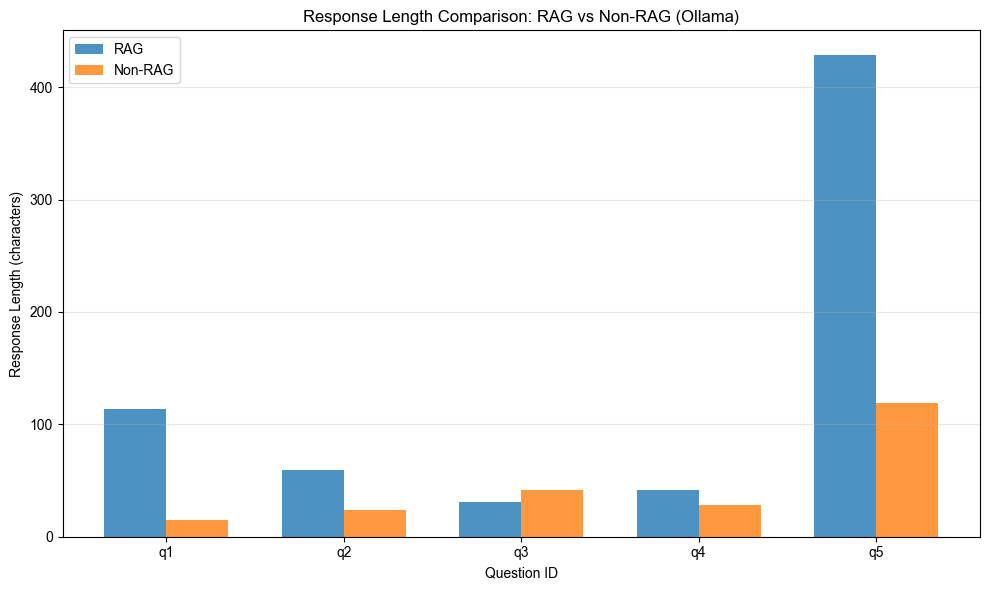


✓ Visualization complete


In [12]:
import matplotlib.pyplot as plt
import matplotlib

# 日本語フォントの設定
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Hiragino Sans', 'Yu Gothic', 'Meiryo']
matplotlib.rcParams['axes.unicode_minus'] = False

# 応答長の比較
fig, ax = plt.subplots(figsize=(10, 6))

question_ids = [r['question_id'] for r in experiment_results]
x = np.arange(len(question_ids))
width = 0.35

ax.bar(x - width/2, rag_lengths, width, label='RAG', alpha=0.8)
ax.bar(x + width/2, no_rag_lengths, width, label='Non-RAG', alpha=0.8)

ax.set_xlabel('Question ID')
ax.set_ylabel('Response Length (characters)')
ax.set_title('Response Length Comparison: RAG vs Non-RAG (Ollama)')
ax.set_xticks(x)
ax.set_xticklabels(question_ids)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

## 11. 次のステップ

このexp_003 (MoE埋め込み版) 実験の完了後:

1. **exp_001との比較**: 埋め込みモデルの違い (nomic-v1 vs nomic-v2 MoE) による検索品質の変化を分析
2. **exp_004の実行**: LM Studio + Phi-3.5 + MoE埋め込みの組み合わせを実験
3. **比較レポート作成**: 4つの実験 (exp_001~004) を総合的に比較
4. **埋め込み品質の評価**: MoEアーキテクチャの効果を定量的に評価

**重要な比較軸:**
- 検索精度: 関連チャンクの取得率
- 応答品質: RAG応答の正確性と詳細度
- 計算コスト: 埋め込み生成時間

---

**実験完了！**  
exp_001の結果と比較して、MoE埋め込みの効果を評価してください。